In [1]:
from bilby.gw.prior import Uniform, DeltaFunction
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device=}")

Using device=device(type='cuda')


In [2]:
sigma = 0.4
num_points = 200

def damped_sho(t, omega_0, beta, shift=0):
    # beta less than 1 for underdamped
    envel = beta * omega_0
    osc = torch.sqrt(1 - beta**2) * omega_0
    tau = t - shift
    data = torch.exp(-envel * tau) * torch.cos(osc * tau)
    data[tau < 0] = 0  # assume oscillator starts at tau = 0
    return data

def get_data(omega_0=None, beta=None, shift=None, num_points=1, priors=None):
    """Sample omega, beta, shift and return a batch of data with noise"""

    omega_0 = priors['omega_0'].sample() if omega_0 is None else omega_0
    omega_0 = torch.tensor(omega_0).to(dtype=torch.float32)
    beta = priors['beta'].sample() if beta is None else beta
    beta = torch.tensor(beta).to(dtype=torch.float32)
    shift = priors['shift'].sample() if shift is None else shift
    shift = torch.tensor(shift).to(dtype=torch.float32)

    t_vals = torch.linspace(-1, 10, num_points).to(dtype=torch.float32) #

    y = damped_sho(t_vals, omega_0=omega_0, beta=beta, shift=shift)
    y += sigma * torch.randn(size=y.size()).to(dtype=torch.float32)

    return t_vals, y, omega_0, beta, shift

In [3]:
num_simulations = 2000
num_repeats = 10

def get_simulations(priors):
    theta_unshifted_vals = []
    theta_shifted_vals = []
    data_unshifted_vals = []
    data_shifted_vals = []

    for ii in range(num_simulations):
        # generated data with a fixed shift
        t_vals, y_unshifted, omega_0, beta, shift = get_data(num_points=num_points, shift=1, priors=priors)
        # create repeats
        theta_unshifted = torch.tensor([omega_0, beta, shift]).repeat(num_repeats, 1).to(device=device)
        theta_unshifted_vals.append(theta_unshifted)
        data_unshifted_vals.append(y_unshifted.repeat(num_repeats, 1).to(device=device))
        # generate shifted data
        theta_shifted = []
        data_shifted = []
        for _ in range(num_repeats):
            t_val, y_shifted, _omega_0, _beta, shift = get_data(
                omega_0=omega_0, beta=beta,  # omega and beta same as above
                shift=None,
                num_points=num_points,
                priors=priors
            )
            theta_shifted.append(torch.tensor([omega_0, beta, shift]))
            data_shifted.append(y_shifted)
        theta_shifted_vals.append(torch.stack(theta_shifted).to(device=device))
        data_shifted_vals.append(torch.stack(data_shifted).to(device=device))
    return theta_shifted_vals, theta_unshifted_vals, data_shifted_vals, data_unshifted_vals

In [4]:
priors_1 = dict()
priors_1['omega_0'] = DeltaFunction(0.2, name='omega_0', latex_label='$omega_0$')
priors_1['beta'] = DeltaFunction(0.45, name='beta', latex_label='$\\beta$')
priors_1['shift'] = Uniform(-4, 4, name='shift', latex_label='$\Delta\;t$')

priors_2 = dict()
priors_2['omega_0'] = DeltaFunction(0.5, name='omega_0', latex_label='$omega_0$')
priors_2['beta'] = DeltaFunction(0.35, name='beta', latex_label='$\\beta$')
priors_2['shift'] = Uniform(-4, 4, name='shift', latex_label='$\Delta\;t$')

priors_3 = dict()
priors_3['omega_0'] = DeltaFunction(0.8, name='omega_0', latex_label='$omega_0$')
priors_3['beta'] = DeltaFunction(0.25, name='beta', latex_label='$\\beta$')
priors_3['shift'] = Uniform(-4, 4, name='shift', latex_label='$\Delta\;t$')

priors_4 = dict()
priors_4['omega_0'] = DeltaFunction(1.1, name='omega_0', latex_label='$omega_0$')
priors_4['beta'] = DeltaFunction(0.15, name='beta', latex_label='$\\beta$')
priors_4['shift'] = Uniform(-4, 4, name='shift', latex_label='$\Delta\;t$')

In [5]:
theta_shifted_1, theta_unshifted_1, data_shifted_1, data_unshifted_1 = get_simulations(priors_1)
theta_shifted_2, theta_unshifted_2, data_shifted_2, data_unshifted_2 = get_simulations(priors_2)
theta_shifted_3, theta_unshifted_3, data_shifted_3, data_unshifted_3 = get_simulations(priors_3)
theta_shifted_4, theta_unshifted_4, data_shifted_4, data_unshifted_4 = get_simulations(priors_4)

/tmp/ipykernel_284441/2737912086.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  omega_0 = torch.tensor(omega_0).to(dtype=torch.float32)
/tmp/ipykernel_284441/2737912086.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(beta).to(dtype=torch.float32)


In [6]:
class DataGenerator(Dataset):
    def __init__(self, *args, **kwargs):
        theta_shifted, theta_unshifted, data_shifted, data_unshifted, *args = args
        self.theta_shifted = theta_shifted
        self.theta_unshifted = theta_unshifted
        self.data_shifted = data_shifted
        self.data_unshifted = data_unshifted
        super().__init__(*args, **kwargs)
    def __len__(self):
        return num_simulations
    def __getitem__(self, idx, param_category=1):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # return shifted and unshifted theta and data
        return (
            self.theta_shifted[idx].to(dtype=torch.float32),
            self.theta_unshifted[idx].to(dtype=torch.float32),
            self.data_shifted[idx].to(dtype=torch.float32),
            self.data_unshifted[idx].to(dtype=torch.float32))

dataset_1 = DataGenerator(theta_shifted_1, theta_unshifted_1, data_shifted_1, data_unshifted_1)
dataset_2 = DataGenerator(theta_shifted_2, theta_unshifted_2, data_shifted_2, data_unshifted_2)
dataset_3 = DataGenerator(theta_shifted_3, theta_unshifted_3, data_shifted_3, data_unshifted_3)
dataset_4 = DataGenerator(theta_shifted_4, theta_unshifted_4, data_shifted_4, data_unshifted_4)

test_data_loader_1 = DataLoader(
    dataset_1, batch_size=1,
    shuffle=False
)
test_data_loader_2 = DataLoader(
    dataset_2, batch_size=1,
    shuffle=False
)
test_data_loader_3 = DataLoader(
    dataset_3, batch_size=1,
    shuffle=False
)
test_data_loader_4 = DataLoader(
    dataset_4, batch_size=1,
    shuffle=False
)

In [7]:
class ConvResidualBlock(nn.Module):
    def __init__(
        self,
        channels,
        kernel_size=5,
        activation=F.relu,
        dropout_probability=0.1,
        use_batch_norm=True,
        zero_initialization=True,
    ):
        super().__init__()
        self.activation = activation

        self.use_batch_norm = use_batch_norm
        if use_batch_norm:
            self.batch_norm_layers = nn.ModuleList(
                [nn.BatchNorm1d(channels, eps=1e-3) for _ in range(2)]
            )
        self.conv_layers = nn.ModuleList(
            [nn.Conv1d(channels, channels, kernel_size=kernel_size, padding='same') for _ in range(2)] #2 is for 2 conv layers
        )
        self.dropout = nn.Dropout(p=dropout_probability)
        if zero_initialization:
            nn.init.uniform_(self.conv_layers[-1].weight, -1e-3, 1e-3)
            nn.init.uniform_(self.conv_layers[-1].bias, -1e-3, 1e-3)

    def forward(self, inputs):
        temps = inputs
        if self.use_batch_norm:
            temps = self.batch_norm_layers[0](temps)
        temps = self.activation(temps)
        temps = self.conv_layers[0](temps)
        if self.use_batch_norm:
            temps = self.batch_norm_layers[1](temps)
        temps = self.activation(temps)
        temps = self.dropout(temps)
        temps = self.conv_layers[1](temps)
        return inputs + temps


class ConvResidualNet(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        hidden_channels,
        num_blocks=2,
        kernel_size=5,
        activation=F.relu,
        dropout_probability=0.1,
        use_batch_norm=True,
    ):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.initial_layer = nn.Conv1d(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
            padding='same',
        )
        self.blocks = nn.ModuleList(
            [
                ConvResidualBlock(
                    channels=hidden_channels,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=use_batch_norm,
                    kernel_size=kernel_size,
                )
                for _ in range(num_blocks)
            ]
        )
        self.final_layer = nn.Conv1d(
            hidden_channels, out_channels, kernel_size=1, padding='same'
        )

    def forward(self, inputs):
        temps = self.initial_layer(inputs)
        for block in self.blocks:
            temps = block(temps)
        outputs = self.final_layer(temps)
        return outputs

num_dim = 3

class SimilarityEmbedding(nn.Module):
    """Simple Dense embedding"""
    def __init__(self, num_hidden_layers_h=1, activation=torch.tanh):
        super().__init__()
        self.num_hidden_layers_h = num_hidden_layers_h

        self.layers_f = ConvResidualNet(in_channels=num_repeats, out_channels=1,
                                        hidden_channels=20, num_blocks=4,
                                        kernel_size=21)
        self.contraction_layer = nn.Sequential(
            nn.Linear(num_points, 100),
            nn.ReLU(),
            nn.Linear(100, num_dim)
        )
        self.expander_layer = nn.Linear(num_dim, 20)
        self.layers_h = nn.ModuleList([nn.Linear(20, 20) for _ in range(num_hidden_layers_h)])
        self.final_layer = nn.Linear(20, 6)

        self.activation = activation

    def forward(self, x):
        x = self.layers_f(x)
        x = self.contraction_layer(x)
        representation = torch.clone(x)
        x = self.activation(self.expander_layer(x))
        for layer in self.layers_h:
            x = layer(x)
            x = self.activation(x)
        x = self.final_layer(x)
        return x, representation

In [8]:
similarity_embedding = SimilarityEmbedding(num_hidden_layers_h=2).to(device)

In [9]:
PATH = './damped-harmonic-oscillator-similarity-embedding-weights.neurips.pth'
similarity_embedding.load_state_dict(torch.load(PATH, map_location=device))
similarity_embedding.eval()

SimilarityEmbedding(
  (layers_f): ConvResidualNet(
    (initial_layer): Conv1d(10, 20, kernel_size=(21,), stride=(1,), padding=same)
    (blocks): ModuleList(
      (0): ConvResidualBlock(
        (batch_norm_layers): ModuleList(
          (0): BatchNorm1d(20, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (1): BatchNorm1d(20, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv_layers): ModuleList(
          (0): Conv1d(20, 20, kernel_size=(21,), stride=(1,), padding=same)
          (1): Conv1d(20, 20, kernel_size=(21,), stride=(1,), padding=same)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): ConvResidualBlock(
        (batch_norm_layers): ModuleList(
          (0): BatchNorm1d(20, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (1): BatchNorm1d(20, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv_layers): ModuleList(
         

In [10]:
similarity_outputs_1 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader_1):
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output)

similarity_outputs_2 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader_2):
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_2.append(similarity_output)

similarity_outputs_3 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader_3):
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_3.append(similarity_output)

similarity_outputs_4 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader_4):
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_4.append(similarity_output)

In [11]:
similarity_outputs_1 = torch.stack(similarity_outputs_1).squeeze()
similarity_outputs_2 = torch.stack(similarity_outputs_2).squeeze()
similarity_outputs_3 = torch.stack(similarity_outputs_3).squeeze()
similarity_outputs_4 = torch.stack(similarity_outputs_4).squeeze()

In [12]:
import corner
import matplotlib.patches as patches

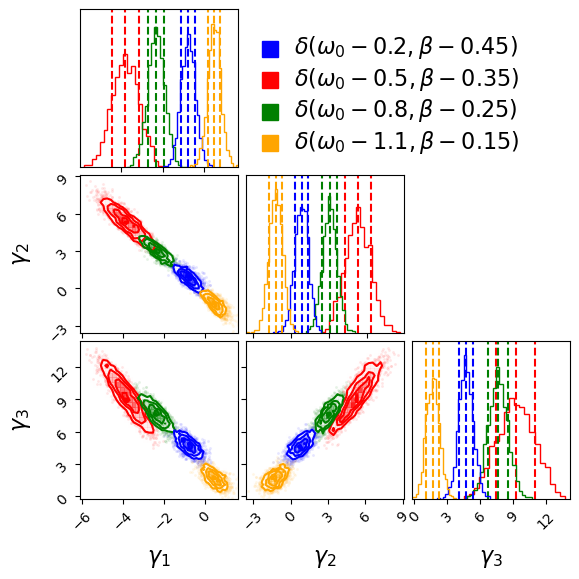

In [14]:
figure = plt.figure(figsize=(6, 6))

figure = corner.corner(
    similarity_outputs_1.cpu().numpy(),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="red",
)

figure = corner.corner(
    similarity_outputs_2.cpu().numpy(),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="green"
)

figure = corner.corner(
    similarity_outputs_3.cpu().numpy(),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="blue"
)

figure = corner.corner(
    similarity_outputs_4.cpu().numpy(),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="orange",
    labels=[r'$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$'],
    label_kwargs=dict(fontsize=16)
)

rect = patches.Rectangle((0.1, 0.7), 0.1, 0.1, fill=True, color='blue')
figure.get_axes()[1].add_patch(rect)
figure.get_axes()[1].text(0.3, 0.72, f"$\\delta(\\{priors_1['omega_0'].name}-{priors_1['omega_0'].peak}, \\{priors_1['beta'].name}-{priors_1['beta'].peak})$", fontsize=16)

rect = patches.Rectangle((0.1, 0.5), 0.1, 0.1, fill=True, color='red')
figure.get_axes()[1].add_patch(rect)
figure.get_axes()[1].text(0.3, 0.52, f"$\\delta(\\{priors_2['omega_0'].name}-{priors_2['omega_0'].peak}, \\{priors_2['beta'].name}-{priors_2['beta'].peak})$", fontsize=16)

rect = patches.Rectangle((0.1, 0.3), 0.1, 0.1, fill=True, color='green')
figure.get_axes()[1].add_patch(rect)
figure.get_axes()[1].text(0.3, 0.32, f"$\\delta(\\{priors_3['omega_0'].name}-{priors_3['omega_0'].peak}, \\{priors_3['beta'].name}-{priors_3['beta'].peak})$", fontsize=16)

rect = patches.Rectangle((0.1, 0.1), 0.1, 0.1, fill=True, color='orange')
figure.get_axes()[1].add_patch(rect)
figure.get_axes()[1].text(0.3, 0.12, f"$\\delta(\\{priors_4['omega_0'].name}-{priors_4['omega_0'].peak}, \\{priors_4['beta'].name}-{priors_4['beta'].peak})$", fontsize=16)

plt.savefig('sho-reps.pdf')